## model1

In [10]:
from data_generator import *
from init_sdr import *
from main import *
from common import *
from measure import *

from cv_model import *

import json

import json

import ray
import time
import warnings

import torch
import argparse
import ray
from ray import tune
from ray.tune import Trainable
from itertools import product
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms
from init_sdr import *

import ray
import copy


import time

from sklearn.model_selection import KFold

import argparse

import shutil

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search import ConcurrencyLimiter
from typing import List, Dict

from ray.tune import CLIReporter
import warnings

from ray.tune.search.bayesopt import BayesOptSearch


import math
from test_model import *
from measure import *



from collections import Counter

In [15]:
torch.set_printoptions(sci_mode=False)


d_seed  = 200

best_config1 = {'h_dim1': 1, 'h_dim2': 20, 'sample_size': 500, 'num_features': 20, 'lambda_0': 0.005,
                'lr': 0.025, 'epoch': 1000, 'seed': -1, 'model_num': 'model1', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'known'}

best_config1['data_seed'] = d_seed 


d_set = SyntheticDataset(sample_size = best_config1['sample_size'], num_features = best_config1['num_features'], model_num = best_config1['model_num'] , seed = best_config1['data_seed'])

d_size = len(d_set)

d_loader = DataLoader(d_set, batch_size = d_size , shuffle=True)
for train_x, train_y in d_loader:
    X, y = train_x, train_y
    
y_mean = torch.mean(y)
mse_mean = torch.mean((y - y_mean) ** 2)
print('Mean model:', mse_mean.item())
print("Std of target:", torch.std(y).item())
# print('cov of X', torch.cov(X.T))
print('shape of X', X.size())
print(best_config1)


train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
print("Estimation of dimension")
print(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))

Mean model: 35.71869659423828
Std of target: 5.9824981689453125
shape of X torch.Size([500, 20])
{'h_dim1': 1, 'h_dim2': 20, 'sample_size': 500, 'num_features': 20, 'lambda_0': 0.005, 'lr': 0.025, 'epoch': 1000, 'seed': -1, 'model_num': 'model1', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'known', 'data_seed': 200}
Estimation of dimension
1


In [16]:
val_mse_list1[-1]

0.38065552711486816

In [17]:
val_custom_list1[-1]

0.3829418122768402

In [5]:
S = torch.linalg.svdvals(model1.state_dict()['layer2.weight'])
print(S)

tensor([4.6059, 2.1448])


In [18]:
print(model1.state_dict()['layer1.weight'])

tensor([[ 0.3802,  0.1884,  0.3785,  0.0021, -0.0081,  0.0065, -0.0075, -0.0039,
          0.0056,  0.0078, -0.0076,  0.0027, -0.0065, -0.0038,  0.0029,  0.0097,
         -0.0026, -0.0027,  0.0023, -0.0009]])


## estimate other method

In [19]:
dnn_est = model1.state_dict()['layer1.weight'].T

sir = sdr(X, y, dim = best_config1['h_dim1'], mode = 'sir')
dr = sdr(X, y, dim = best_config1['h_dim1'], mode = 'dr')
save = sdr(X, y, dim = best_config1['h_dim1'], mode = 'save')
mave = sdr(X, y, dim = best_config1['h_dim1'], mode = 'mave')
rmave = sdr(X, y, dim = best_config1['h_dim1'], mode = 'rmave')

## General loss

In [20]:
true_est = CMS(best_config1['model_num'], X)

In [21]:
print("Our model General Loss:", general_loss(dnn_est, true_est))
print("SIR General Loss:", general_loss(sir, true_est))
print("SAVE General Loss:", general_loss(save, true_est))
print("DR General Loss:", general_loss(dr, true_est))
print("MAVE General Loss:", general_loss(mave, true_est))
print("rMAVE General Loss:", general_loss(rmave, true_est))

Our model General Loss: 0.0032157613895833492
SIR General Loss: 0.14166158437728882
SAVE General Loss: 0.18684054911136627
DR General Loss: 0.2463175505399704
MAVE General Loss: 0.11272571235895157
rMAVE General Loss: 0.018787777051329613


## Projection Loss

In [22]:
print("Our model Projection Loss:", projection_loss(dnn_est, true_est))
print("SIR Projection Loss:", projection_loss(sir, true_est))
print("SAVE Projection Loss:", projection_loss(save, true_est))
print("DR Projection Loss:", projection_loss(dr, true_est))
print("MAVE Projection Loss:", projection_loss(mave, true_est))
print("rMAVE Projection Loss:", projection_loss(rmave, true_est))

Our model Projection Loss: 0.0032157618552446365
SIR Projection Loss: 0.14166156947612762
SAVE Projection Loss: 0.18684054911136627
DR Projection Loss: 0.24631758034229279
MAVE Projection Loss: 0.11272571235895157
rMAVE Projection Loss: 0.01878778077661991


## Prediction Loss

In [23]:
best_config1['data_seed'] = d_seed**2


d_set = SyntheticDataset(sample_size = best_config1['sample_size'], num_features = best_config1['num_features'], model_num = best_config1['model_num'] , seed = best_config1['data_seed'])

d_size = len(d_set)

d_loader = DataLoader(d_set, batch_size = d_size , shuffle=True)
for train_x, train_y in d_loader:
    new_X, _ = train_x, train_y


print("Our model Correlation_loss:", Correlation_loss(dnn_est, true_est, new_X))
print("SIR Correlation_loss:", Correlation_loss(sir, true_est, new_X))
print("SAVE Correlation_loss:", Correlation_loss(save, true_est, new_X))
print("DR Correlation_loss:", Correlation_loss(dr, true_est, new_X))
print("MAVE Correlation_loss:", Correlation_loss(mave, true_est, new_X))
print("rMAVE Correlation_loss:", Correlation_loss(rmave, true_est, new_X))

Our model Correlation_loss: 0.0005922317504882812
SIR Correlation_loss: 0.027440369129180908
SAVE Correlation_loss: 0.032694458961486816
DR Correlation_loss: 0.044051945209503174
MAVE Correlation_loss: 0.023510634899139404
rMAVE Correlation_loss: 0.0028000473976135254


# sample 100

In [12]:
torch.set_printoptions(sci_mode=False)

dim_list = []

print(best_config1)
for i in range(100):
    best_config1['data_seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res1 = Counter(dim_list)
print(res1)

{'h_dim1': 10, 'h_dim2': 20, 'sample_size': 500, 'num_features': 20, 'lambda_0': 0.005, 'lambda_1': 2.5, 'lr': 0.0025, 'epoch': 5000, 'seed': -1, 'model_num': 'model1', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'unknown', 'data_seed': 200}
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration


KeyboardInterrupt: 

## sample 200

In [ ]:
best_config1['sample_size'] = 200
dim_list = []
print(best_config1)
for i in range(100):
    best_config1['data_seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res2 = Counter(dim_list)
print(res2)

{'h_dim1': 10, 'h_dim2': 20, 'sample_size': 200, 'num_features': 20, 'lambda_0': 0.05, 'lambda_1': 0.01, 'lr': 0.0005, 'epoch': 5000, 'seed': -1, 'model_num': 'model1', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'unknown', 'data_seed': 100}
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration


In [20]:
best_config1['sample_size'] = 200
print(best_config1)
for i in range(100):
    best_config1['data_seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    print(model1.state_dict()['layer1.weight'])

{'h_dim1': 1, 'h_dim2': 20, 'sample_size': 200, 'num_features': 20, 'lambda_0': 0.001, 'lr': 0.00025, 'epoch': 2000, 'seed': -1, 'model_num': 'model2', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'known', 'data_seed': -1}
1 iteration
tensor([[ 0.2296,  0.4956,  0.7658,  0.4515, -0.6526,  0.3891,  0.4414, -0.1398,
          0.3237, -0.1823,  0.4606,  0.3069, -0.2081,  0.1355, -0.2089,  0.1600,
          0.2243, -0.2878,  0.1959, -0.0518]])
2 iteration
tensor([[-0.5899, -0.5829, -0.6830, -0.4332, -0.1759, -0.1072,  0.0357,  0.3604,
         -0.6653,  0.2302, -0.2686,  0.2838, -0.4027,  0.2363, -0.1994,  0.5544,
         -0.2817, -0.0178, -0.0235,  0.0660]])
3 iteration
tensor([[-0.2973, -0.3338, -0.2532, -0.3761,  0.0008,  0.0501, -0.0235, -0.0378,
         -0.0054, -0.2073, -0.0068,  0.0921,  0.0805, -0.1361,  0.0677, -0.1601,
          0.3322, -0.0401,  0.0118, -0.2330]])
4 iteration
tensor([[ 0.4842,  0.5997,  1.0141,  0.7944,  0.4398,  0.1143,  0.6003, -0.0091,
         -0.0793, -0.2952,  0

# sample 500

In [29]:
best_config1['sample_size'] = 500
dim_list = []
for i in range(100):
    best_config1['data_seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res3 = Counter(dim_list)
print(res3)

1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration
26 iteration
27 iteration
28 iteration
29 iteration
30 iteration
31 iteration
32 iteration
33 iteration
34 iteration
35 iteration
36 iteration
37 iteration
38 iteration
39 iteration
40 iteration
41 iteration
42 iteration
43 iteration
44 iteration
45 iteration
46 iteration
47 iteration
48 iteration
49 iteration
50 iteration
51 iteration
52 iteration
53 iteration
54 iteration
55 iteration
56 iteration
57 iteration
58 iteration
59 iteration
60 iteration
61 iteration
62 iteration
63 iteration
64 iteration
65 iteration
66 iteration
67 iteration
68 iteration
69 iteration
70 iteration
71 iteration
72 iteration
73 iteration
74 iteration
75 iteration
76 iteration
77 iteration
78 itera

# sample 1000

In [30]:
best_config1['sample_size'] = 1000
dim_list = []
for i in range(100):
    best_config1['seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res4 = Counter(dim_list)
print(res4)

1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration
11 iteration
12 iteration
13 iteration
14 iteration
15 iteration
16 iteration
17 iteration
18 iteration
19 iteration
20 iteration
21 iteration
22 iteration
23 iteration
24 iteration
25 iteration
26 iteration
27 iteration
28 iteration
29 iteration
30 iteration
31 iteration
32 iteration
33 iteration
34 iteration
35 iteration
36 iteration
37 iteration
38 iteration
39 iteration
40 iteration
41 iteration
42 iteration
43 iteration
44 iteration
45 iteration
46 iteration
47 iteration
48 iteration
49 iteration
50 iteration
51 iteration
52 iteration
53 iteration
54 iteration
55 iteration
56 iteration
57 iteration
58 iteration
59 iteration
60 iteration
61 iteration
62 iteration
63 iteration
64 iteration
65 iteration
66 iteration
67 iteration
68 iteration
69 iteration
70 iteration
71 iteration
72 iteration
73 iteration
74 iteration
75 iteration
76 iteration
77 iteration
78 itera

# 500

In [ ]:
best_config1['sample_size'] = 500
dim_list = []
for i in range(100):
    best_config1['seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res4 = Counter(dim_list)
print(res4)

# sample 20000

In [ ]:
best_config1['seed'] = 10000
for i in range(100):
    best_config1['seed'] = i 
    print(i+1,'iteration')
    train_mse_list1, val_mse_list1, train_custom_list1, val_custom_list1, model1 = train_model(best_config1, state = 'test')
    print("Estimation of dimension")
    print(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
    dim_list.append(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
print(len(nonzero_dim(model1.state_dict()['layer2.weight'].T, 1e-5)))
res4 = Counter(dim_list)
res4

## plot

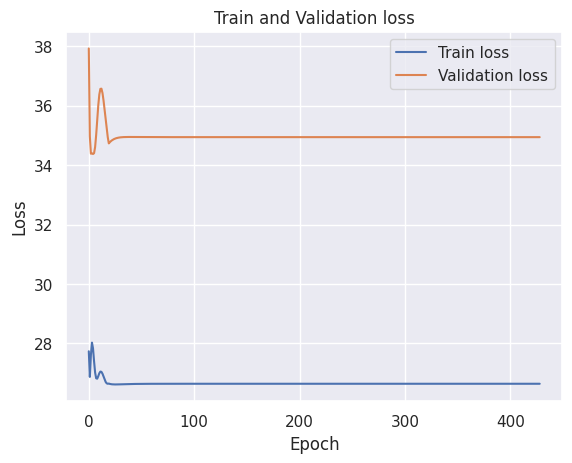

In [4]:
plt.plot(train_mse_list1, label='Train loss')
plt.plot(val_mse_list1, label='Validation loss')
plt.title('Train and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

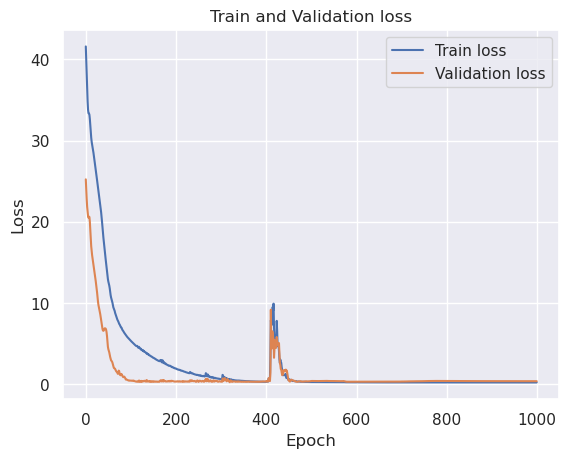

In [24]:
plt.plot(train_custom_list1, label='Train loss')
plt.plot(val_custom_list1, label='Validation loss')
plt.title('Train and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
print(model1.state_dict()['layer2.weight'].size())

torch.Size([20, 10])


In [223]:
true_beta = torch.zeros(20, 1)
true_beta[0] = 1.0
true_beta[1] = 0.5
true_beta[2] = 1.0

true_beta  = true_beta / torch.norm(true_beta)

from measure import *

est_beta = model1.state_dict()['layer1.weight'][nonzero_dim(model1.state_dict()['layer2.weight'].T,1e-5),:]

In [224]:
true_beta.size()

torch.Size([20, 1])

In [227]:
est_beta = est_beta / torch.norm(est_beta)

In [228]:
print(general_loss(est_beta, true_beta.T))
print(projection_loss(est_beta, true_beta.T))

0.7947604656219482
0.794760525226593


In [229]:
dr_beta, _, _ = sdr_init(X, y, 1)

print(general_loss(dr_beta.T, true_beta.T))
print(projection_loss(dr_beta.T, true_beta.T))

0.06769052892923355
0.06769052892923355


In [230]:
from init_sdr import *

sir_beta = sdr(X, y, dim = 1, mode = 'sir')
print(sir_beta.size())

torch.Size([20, 1])


In [231]:
print(general_loss(sir_beta.T, true_beta.T))
print(projection_loss(sir_beta.T, true_beta.T))

0.09616237133741379
0.09616237133741379
